# Paper title: Intrinsic and Extrinsic Evalutions of PalmTree Instruction embeddings and Improvement with Deep Metric Learning
## Target CCS, deadline: ??


## **Overview**


First, compute embeddings for each sequences in the basic blocks.

**Intrinsic Evaluations**
* operand based outlier detection, and 
* basic block similarity search. 
*   Analyze how effective basic block search is
*   Improve it by encoding pairs, or more instructions at a time
*   Do deep metric learning to improve distance matching/basic block search

**Extrinisic Evaluations**
*    Sajib - Binary code similarity detection
*    Tim - Function type signature
*    Liza - Value Set Analysis



**Basic Block Search** 
*   Do analysis, how effective the embeddings to characterize similiarities between basic blocks 
*   Average cosine distance used as similarity 
*   We didn't need training data for outlier detection.
But, we need training data for basic block search.
EER is used by many for accuracy

**Possible improvment**
*   Given a basic block, if encodes one instruction at time, then take average
*   Problem for instructions that are dependant on others
*   PalmTree only takes average of the instructions embeddings in a basic block.
*    Should we need to change this? Possiblye, Embed two or more instructions together, not just one

**Metric learning** "Deep Metric Learning to Rank"
*   If dataset is available, apply FastAP
*   It improves the outlier detection based on opcode by a lot







## Initialize Colab & Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install bert-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pytorch-metric-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 5.1 MB/s 


In [4]:
% cd /content/drive/MyDrive/Colab\ Notebooks/PalmTree-Trained/
% ls

/content/drive/.shortcut-targets-by-id/1LMg3kN9NvUURy3zB07RjiMQNzN0TPyMm/PalmTree-Trained
 add_cosine_sim_sorted_final.pdf
 add_cosine_sim_sorted.pdf
 bb_sim.pdf
 config.py
'Cosine Distribution Data'/
'Embedding Distribuitions.pdf'
 eval_utils.py
 hex1_cosine_sim_sorted_final.pdf
 hex1_cosine_sim_sorted.pdf
 histogram_final.pdf
 histogram.pdf
 how2use.py
 ins_cosine_sim_sorted_final.pdf
 ins_cosine_sim_sorted.pdf
 ins_MOV_cosine_sim_sorted.pdf
 intrinsic_eval/
 max_acc_list.txt
 metric_embeddings.txt
 min_acc_list.txt
 model.pth
 model_sb.pth
 opcode_instructions_embeddings.pkl
 opcode_instructions_metric_embeddings.pkl
 operand_instructions_embeddings.pkl
 operand_instructions_metric_embeddings.pkl
 op_palmtree.pkl
 palmtree/
 PalmTree/
'Plot PDFs'/
 __pycache__/
 result_matrix.gdoc
 result_matrix.txt
 testing_accuracy.txt
 testing_losses.txt
 test_npz_inst.npz
 token_embeddings_magnitude_distributions_final.pdf
 token_embeddings_magnitude_distributions.pdf
 training_accuracy.txt
 Tra

## Intrinsic Evaluation -- Basic Block Similarity Search

### Import Libraries and Load the PalmTree Model

In [ ]:
import os
import matplotlib.pyplot as plt
from torch import nn
from scipy.ndimage.filters import gaussian_filter1d
from torch.autograd import Variable
import torch
import numpy as np
from numpy import trapz
import eval_utils as utils
import re
import pickle
from matplotlib import rcParams
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


# read test data
usable_pt = utils.UsableTransformer(model_path="./palmtree/transformer.ep19", vocab_path="./palmtree/vocab")

ground_truth_file = "./intrinsic_eval/mapping.pkl"

with open(ground_truth_file, 'rb') as f:
    ground_truth_bb_pairs = pickle.load(f)

num_of_pairs = len(ground_truth_bb_pairs)

pt_embeddings_1 = []
pt_embeddings_2 = []


bin1_mapping = {}
bin2_mapping = {}


for key, text in ground_truth_bb_pairs.items():
    text0 = [t for t in text[0].split(';') if t]
    text1 = [t for t in text[1].split(';') if t]

    pt_embeddings_1.append(usable_pt.encode(text0).sum(axis=0)/len(text0))
    bin1_mapping[key] = len(pt_embeddings_1) - 1

    pt_embeddings_2.append(usable_pt.encode(text1).sum(axis=0)/len(text1))
    bin2_mapping[key] = len(pt_embeddings_2) - 1  


Loading Vocab ./palmtree/vocab
Vocab Size:  6631


### Dataset used for Basic Block Search [Optional]

In [ ]:
#Check out the dataset
for key, text in ground_truth_bb_pairs.items():
  print(key,'\t',text[0])
  print('\t\t',text[1])
print('# of items in \'ground_truth_bb_pairs\':', len(ground_truth_bb_pairs))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



elfedit.ve11 	 push  rbp ;mov  rbp   rsp ;sub  rsp   0x1b0 ;lea  rax  [ rbp - 0xb8 ];xor  r8d   r8d ;mov  qword  [ rbp - 0x10 ]  rdi ;mov  qword  [ rbp - 0x18 ]  rsi ;mov  dword  [ rbp - 0x1c ]  edx ;mov  qword  [ rbp - 0xb8 ]  0x0 ;mov  qword  [ rbp - 0xb0 ]  0x0 ;mov  qword  [ rbp - 0xa0 ]  0x0 ;mov  qword  [ rbp - 0x98 ]  0x0 ;mov  qword  [ rbp - 0x88 ]  0x0 ;mov  qword  [ rbp - 0x150 ]  0x0 ;mov  qword  [ rbp - 0x148 ]  0x0 ;mov  qword  [ rbp - 0x138 ]  0x0 ;mov  qword  [ rbp - 0x130 ]  0x0 ;mov  qword  [ rbp - 0x120 ]  0x0 ;mov  rsi   qword  [ rbp - 0x10 ];mov  rdx   qword  [ rbp - 0x18 ];mov  ecx   dword  [ rbp - 0x1c ];mov  rdi   rax ;call  symbol ;cmp  eax   0x0 ;je  address ;mov  dword  [ rbp - 0x15c ]  0x0 ;mov  dword  [ rbp - 0x15c ]  0x1 ;jmp  address ;mov  eax   0x1 ;mov  esi   eax ;mov  eax   0x3c ;mov  edx   eax ;lea  rcx  [ rbp - 0xb8 ];add  rcx   0x58 ;mov  rdi   qword  [ rbp - 0x18 ];mov  qword  [ rbp - 0x190 ]  rdi ;mov  rdi   rcx ;mov  rcx   qword  [ rbp - 0x190 ];c

In [ ]:
print('# of items in \'bin1_mapping\':', len(bin1_mapping))
print(bin1_mapping.items())

# of items in 'bin1_mapping': 1868
dict_items([('b2sum.it0', 0), ('b2sum.it1', 1), ('b2sum.it2', 2), ('b2sum.ow0', 3), ('b2sum.nv0', 4), ('b2sum.ee0', 5), ('b2sum.rt0', 6), ('b2sum.on0', 7), ('b2sum.mp0', 8), ('b2sum.py0', 9), ('b2sum.ng0', 10), ('b2sum.or0', 11), ('b2sum.ad0', 12), ('b2sum.tl0', 13), ('b2sum.in0', 14), ('b2sum.se0', 15), ('b2sum.xt0', 16), ('b2sum.ax0', 17), ('b2sum.en0', 18), ('b2sum.wc0', 19), ('b2sum.hr0', 20), ('b2sum.ek0', 21), ('b2sum.il0', 22), ('b2sum.al0', 23), ('b2sum.et0', 24), ('b2sum.nf0', 25), ('b2sum.ed0', 26), ('b2sum.oc0', 27), ('b2sum.im0', 28), ('b2sum.of0', 29), ('b2sum.no0', 30), ('b2sum.sh0', 31), ('b2sum.fo0', 32), ('b2sum.tc0', 33), ('b2sum.le0', 34), ('b2sum.hk0', 35), ('b2sum.uf0', 36), ('b2sum.ko0', 37), ('b2sum.ul0', 38), ('b2sum.te0', 39), ('b2sum.nt0', 40), ('b2sum.__0', 41), ('b2sum.es0', 42), ('b2sum.es1', 43), ('b2sum.es2', 44), ('b2sum.es3', 45), ('b2sum.ux0', 46), ('b2sum.ux1', 47), ('b2sum.ux2', 48), ('b2sum.my0', 49), ('b2sum.my1',

In [ ]:
#print(np.asarray(pt_embeddings_1))
print('Shape of \'pt_embeddings_1\':', np.asarray(pt_embeddings_1).shape)
print('Shape of \'pt_embeddings_2\':', np.asarray(pt_embeddings_2).shape)

Shape of 'pt_embeddings_1': (1868, 128)
Shape of 'pt_embeddings_2': (1868, 128)


In [ ]:
#Save the embeddings in two seperate files for later use
pt_embeddings_1_save = './intrinsic_eval/pt_embeddings_1.pkl'
with open(pt_embeddings_1_save, 'wb') as handle:
    pickle.dump(pt_embeddings_1, handle)

bin1_mapping_save = './intrinsic_eval/bin1_mapping.pkl'
with open(bin1_mapping_save, 'wb' ) as handle:
  pickle.dump(bin1_mapping, handle)

pt_embeddings_2_save = './intrinsic_eval/pt_embeddings_2.pkl'
with open(pt_embeddings_2_save, 'wb') as handle:
    pickle.dump(pt_embeddings_2, handle)

bin2_mapping_save = './intrinsic_eval/bin2_mapping.pkl'
with open(bin2_mapping_save, 'wb' ) as handle:
  pickle.dump(bin2_mapping, handle)

### Evaluation

In [ ]:
num_positive = len(ground_truth_bb_pairs)
num_negative = len(ground_truth_bb_pairs) * len(pt_embeddings_2) - num_positive

print('# of postives:', num_positive)
print('# of negatives:', num_negative)
print("start")

pt_target_rank_lst = []

for key in ground_truth_bb_pairs.keys():
    idx = bin1_mapping[key]
    idy = bin2_mapping[key]

    pt_source = pt_embeddings_1[idx]

    pt_target = pt_embeddings_2[idy]

    pt_target_distance = np.linalg.norm(pt_source-pt_target)

    pt_distance_lst = []

    for i in range(len(pt_embeddings_2)):
        pt_distance_lst.append(np.linalg.norm(pt_source-pt_embeddings_2[i]))
    #print('For',idx,':',pt_distance_lst)
    pt_target_rank_lst.append(sorted(pt_distance_lst).index(pt_target_distance))

# of postives: 1868
# of negatives: 3487556
start


In [ ]:
print(pt_target_rank_lst)
print('# of items in \'pt_target_rank_lst\':',len(pt_target_rank_lst))

[1820, 1677, 1863, 66, 65, 1814, 1729, 1504, 24, 64, 16, 57, 46, 1774, 51, 65, 17, 1826, 54, 1780, 59, 6, 5, 1667, 1769, 20, 1718, 17, 12, 60, 63, 1841, 2, 1850, 1846, 65, 0, 1842, 1848, 1853, 1852, 46, 1533, 11, 4, 0, 0, 0, 2, 1, 0, 1, 2, 22, 68, 0, 2, 2, 4, 0, 1, 24, 9, 22, 20, 34, 30, 37, 27, 19, 28, 29, 28, 39, 232, 26, 18, 71, 30, 42, 46, 183, 31, 211, 150, 209, 204, 188, 141, 97, 117, 51, 174, 172, 154, 197, 63, 23, 56, 114, 88, 164, 47, 3, 19, 80, 140, 93, 158, 130, 44, 157, 74, 168, 120, 76, 125, 85, 104, 51, 41, 147, 174, 177, 67, 138, 186, 117, 131, 132, 156, 67, 131, 173, 176, 110, 170, 156, 152, 169, 176, 180, 159, 177, 165, 109, 140, 120, 120, 130, 124, 104, 120, 131, 139, 150, 153, 128, 115, 133, 144, 158, 159, 149, 148, 108, 138, 109, 117, 121, 85, 107, 89, 89, 105, 120, 111, 95, 113, 137, 114, 127, 119, 116, 68, 79, 62, 82, 91, 57, 77, 53, 52, 62, 51, 45, 37, 14, 52, 48, 66, 37, 51, 16, 2, 11, 19, 0, 5, 9, 9, 0, 21, 20, 12, 33, 5, 11, 16, 23, 10, 3, 9, 36, 20, 14, 30, 2

AUC(Area Under Curve) = 0.79


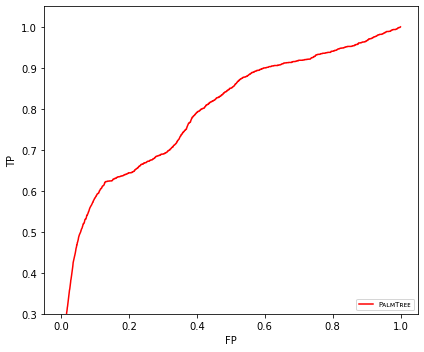

In [ ]:
# calculate & draw ROC curve
from sklearn.metrics import auc
pt_total_tp = []
pt_total_fp = []

for rank in range(1, len(pt_embeddings_2)):
    acc_pt = 0
    fp_pt = 0

    for i in range(len(pt_target_rank_lst)):
        if pt_target_rank_lst[i] < rank:
            acc_pt += 1
            fp_pt += rank -1
        else:
            fp_pt += rank
    #print('for rank #%d, acc is %d, fp is %d '% (rank, acc_pt, fp_pt))
    pt_total_tp.append(acc_pt / num_positive)
    pt_total_fp.append(fp_pt / num_negative)



font1 = {'family' : 'DejaVu Sans',
'weight' : 'normal',
'size'   : 7,
}

# cfg_total_tp = gaussian_filter1d(cfg_total_tp, sigma=2) # make it smooth
roc_auc1 = auc(pt_total_fp, pt_total_tp)
plt.figure(figsize=(6, 5))

plt.plot(pt_total_fp, pt_total_tp, 'r-', label='PᴀʟᴍTʀᴇᴇ')
plt.legend(loc='lower right', prop=font1)
plt.xlim([-0.05, 1.05])
plt.ylim([0.3, 1.05])
plt.ylabel('TP')
plt.xlabel('FP')

plt.tight_layout()
plt.savefig(fname="bb_sim.pdf",format="pdf")
print('AUC(Area Under Curve) = %0.2f' % (roc_auc1))

## Metric Learning on Basic Blocks

### First try the embeddings already generated (SKIP)

In [ ]:
# This script does not need to be run, the accuracy of this method is only 82% and the ROC curve will
# Currently only display the next embedding network which is trained on the basic blocks

import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_metric_learning import losses, reducers
import statistics

class Embedding(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(Embedding, self).__init__()

    self.l1 = nn.Linear(input_dim, hidden_dim)
    self.l2 = nn.Linear(hidden_dim, hidden_dim)
    self.l3 = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, embedding):

    out = self.l1(embedding)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)

    return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Embedding(128, 256, 128).to(device)
model.load_state_dict(torch.load("model.pth"))

pt_embeddings_1_metric = []
pt_embeddings_2_metric = []

for item in pt_embeddings_1:
  metric_embedding = model(torch.Tensor(item).to(device))
  pt_embeddings_1_metric.append(metric_embedding)

for item in pt_embeddings_2:
  metric_embedding = model(torch.Tensor(item).to(device))
  pt_embeddings_2_metric.append(metric_embedding)

KeyboardInterrupt: ignored

### **Trying** **metric** **learning** **on** **basic** **blocks** **directly**

In [ ]:
#Get the embeddings from the two save files
pt_embeddings_1_save = './intrinsic_eval/pt_embeddings_1.pkl'
with open(pt_embeddings_1_save, 'rb') as f:
    pt_embeddings_1 = pickle.load(f)

bin1_mapping_save = './intrinsic_eval/bin1_mapping.pkl'
with open(bin1_mapping_save, 'rb' ) as f:
  bin1_mapping = pickle.load(f)

pt_embeddings_2_save = './intrinsic_eval/pt_embeddings_2.pkl'
with open(pt_embeddings_2_save, 'rb') as f:
    pt_embeddings_2 = pickle.load(f)

bin2_mapping_save = './intrinsic_eval/bin2_mapping.pkl'
with open(bin2_mapping_save, 'rb' ) as f:
  bin2_mapping = pickle.load(f)

In [ ]:
# Generate negative samples, may be inefficient
# Need to create a list of torch tensors containing 
# every other basic block embedding except the ones 
# at the current index
num_of_samples =  num_of_pairs/2

negative_samples = []
for i, emb in enumerate(pt_embeddings_1[:num_of_samples]):
  neg_cur = []
  for j, vec in enumerate(pt_embeddings_2[:num_of_samples]):
    if i != j:
      neg_cur.append(pt_embeddings_1[j])
      neg_cur.append(pt_embeddings_2[j])
  negative_samples.append(neg_cur)

negative_samples = torch.Tensor(negative_samples)
print(negative_samples.shape)

torch.Size([156, 310, 128])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  from ipykernel import kernelapp as app


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_metric_learning import losses, reducers
from pytorch_metric_learning.distances import SNRDistance, CosineSimilarity
import statistics

class Embedding(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(Embedding, self).__init__()

    self.l1 = nn.Linear(input_dim, hidden_dim)
    self.l2 = nn.Linear(hidden_dim, hidden_dim)
    self.l3 = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, embedding):

    out = self.l1(embedding)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)

    return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Embedding(128, 256, 128).to(device)
learning_rate = .001
reducer = reducers.MeanReducer()
criterion = losses.TripletMarginLoss(1.2, reducer, triplets_per_anchor='all', distance=CosineSimilarity())
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=.9)
epochs = 500

# Using half of the data for training
anchor_data = torch.Tensor(pt_embeddings_1[:num_of_samples])
pos_data = torch.Tensor(pt_embeddings_2[:num_of_samples])

ref_neg_labels = torch.ones([310])
ref_pos_labels = torch.zeros([1])
anchor_label = torch.zeros([1])
ref_labels = torch.cat((ref_pos_labels, ref_neg_labels), dim=0)

for epoch in range(epochs):
  for i, vec in enumerate(anchor_data):
    vec = vec.to(device)
    pos = pos_data[i].to(device)
    pos = pos.unsqueeze(dim=0)
    neg = negative_samples[i].to(device)
    ref_vectors = torch.cat((pos, neg), dim=0)

    anchor_embedding = model(vec)
    ref_embeddings = model(ref_vectors)

    optimizer.zero_grad()
    anchor_embedding = anchor_embedding.unsqueeze(dim=0)

    loss = criterion(anchor_embedding, anchor_label, ref_emb=ref_embeddings, ref_labels=ref_labels)
    print("Iteration {} Loss: {}".format(i, loss.item()))

    loss.backward()
    optimizer.step()

Streaming output truncated to the last 5000 lines.
Iteration 148 Loss: 0.79933100938797
Iteration 149 Loss: 0.8266924619674683
Iteration 150 Loss: 0.7628406882286072
Iteration 151 Loss: 0.8391913771629333
Iteration 152 Loss: 0.3573158383369446
Iteration 153 Loss: 0.3808702826499939
Iteration 154 Loss: 0.35999658703804016
Iteration 155 Loss: 0.6453821063041687
Iteration 0 Loss: 0.4810352027416229
Iteration 1 Loss: 0.23317298293113708
Iteration 2 Loss: 0.2102283388376236
Iteration 3 Loss: 0.47950634360313416
Iteration 4 Loss: 0.47976115345954895
Iteration 5 Loss: 0.47920307517051697
Iteration 6 Loss: 0.4721481204032898
Iteration 7 Loss: 0.4713638424873352
Iteration 8 Loss: 0.4803560972213745
Iteration 9 Loss: 0.4754009246826172
Iteration 10 Loss: 0.4708619713783264
Iteration 11 Loss: 0.4702896177768707
Iteration 12 Loss: 0.47824665904045105
Iteration 13 Loss: 0.47404342889785767
Iteration 14 Loss: 0.4918288290500641
Iteration 15 Loss: 0.49604660272598267
Iteration 16 Loss: 0.497998535633

In [ ]:
pt_embeddings_1_metric = []
pt_embeddings_2_metric = []

# Not using the second half for the test set, 
# cannot split ground_truth_bb_pairs, needs to be fixed

test_pt_1 = pt_embeddings_1
test_pt_2 = pt_embeddings_2

for item in test_pt_1:
  metric_embedding = model(torch.Tensor(item).to(device))
  pt_embeddings_1_metric.append(metric_embedding)

for item in test_pt_2:
  metric_embedding = model(torch.Tensor(item).to(device))
  pt_embeddings_2_metric.append(metric_embedding)

In [ ]:
num_positive = len(ground_truth_bb_pairs)
num_negative = len(ground_truth_bb_pairs) * len(pt_embeddings_2_metric) - num_positive

print('# of postives:', num_positive)
print('# of negatives:', num_negative)
print("start")

pt_target_rank_lst = []

print(ground_truth_bb_pairs)

# Currently not splitting the ground_truth_bb_pairs to separate the training and test set
for key in ground_truth_bb_pairs.keys():
    idx = bin1_mapping[key]
    idy = bin2_mapping[key]

    pt_source = pt_embeddings_1_metric[idx].detach().cpu().numpy()

    pt_target = pt_embeddings_2_metric[idy].detach().cpu().numpy()

    pt_target_distance = np.linalg.norm(pt_source-pt_target)

    pt_distance_lst = []

    for i in range(len(pt_embeddings_2_metric)):
        pt_distance_lst.append(np.linalg.norm(pt_source-pt_embeddings_2_metric[i].detach().cpu().numpy()))
    #print('For',idx,':',pt_distance_lst)
    pt_target_rank_lst.append(sorted(pt_distance_lst).index(pt_target_distance))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(pt_target_rank_lst)

[1747, 93, 3, 40, 17, 89, 149, 327, 44, 74, 61, 31, 79, 73, 32, 93, 29, 80, 97, 104, 44, 12, 157, 54, 79, 58, 180, 50, 87, 77, 89, 116, 62, 391, 104, 107, 51, 148, 40, 101, 151, 140, 9, 10, 5, 5, 2, 1, 0, 2, 0, 1, 13, 224, 35, 14, 33, 43, 43, 4, 7, 17, 21, 30, 21, 29, 34, 29, 30, 27, 33, 31, 29, 6, 15, 36, 15, 27, 19, 38, 7, 23, 8, 0, 0, 22, 1, 0, 1, 0, 3, 2, 3, 0, 4, 4, 1, 0, 0, 6, 0, 0, 3, 8, 1, 4, 3, 8, 11, 0, 7, 12, 1, 32, 27, 25, 0, 0, 16, 1, 13, 13, 3, 9, 0, 0, 15, 2, 2, 1, 5, 0, 1, 0, 3, 1, 0, 2, 16, 1, 58, 20, 14, 186, 40, 8, 10, 123, 24, 176, 164, 84, 134, 111, 25, 47, 42, 105, 85, 175, 35, 619, 145, 16, 103, 361, 9, 740, 688, 317, 603, 487, 578, 360, 40, 374, 96, 56, 334, 92, 48, 664, 234, 446, 277, 0, 756, 201, 482, 185, 608, 700, 636, 413, 559, 532, 513, 622, 669, 669, 540, 492, 535, 591, 640, 696, 599, 118, 620, 298, 661, 734, 663, 232, 554, 607, 210, 85, 400, 351, 406, 346, 706, 435, 404, 321, 654, 347, 229, 60, 204, 58, 262, 413, 65, 159, 69, 13, 78, 85, 25, 386, 25, 55,

AUC(Area Under Curve) = 0.78


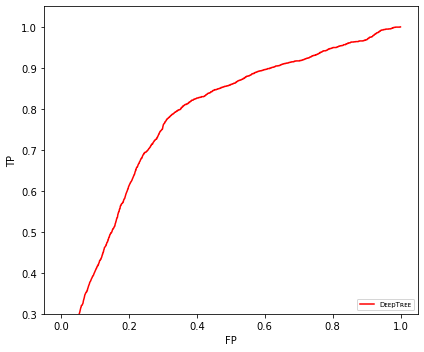

In [ ]:
from sklearn.metrics import auc
# Test metric embeddings
pt_total_tp = []
pt_total_fp = []

for rank in range(1, len(pt_embeddings_2_metric)):
    acc_pt = 0
    fp_pt = 0

    for i in range(len(pt_target_rank_lst)):
        if pt_target_rank_lst[i] < rank:
            acc_pt += 1
            fp_pt += rank -1
        else:
            fp_pt += rank

    pt_total_tp.append(acc_pt / num_positive)
    pt_total_fp.append(fp_pt / num_negative)

font1 = {'family' : 'DejaVu Sans',
'weight' : 'normal',
'size'   : 7,
}

# cfg_total_tp = gaussian_filter1d(cfg_total_tp, sigma=2) # make it smooth
roc_auc1 = auc(pt_total_fp, pt_total_tp)
plt.figure(figsize=(6, 5))

plt.plot(pt_total_fp, pt_total_tp, 'r-', label='DᴇᴇpTʀᴇᴇ')
plt.legend(loc='lower right', prop=font1)
plt.xlim([-0.05, 1.05])
plt.ylim([0.3, 1.05])
plt.ylabel('TP')
plt.xlabel('FP')

plt.tight_layout()
plt.savefig(fname="bb_sim.pdf",format="pdf")
print('AUC(Area Under Curve) = %0.2f' % (roc_auc1))

## Intrinsic Evaluation -- Operand-based Outlier Detection

### Import Libraries and Load the PalmTree Model

In [ ]:
#Import Libraries and Load the PalmTree model
import os
from config import *
from torch import nn
from scipy.ndimage.filters import gaussian_filter1d
import vocab

import random
import time
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from multiprocessing.dummy import Pool as ThreadPool
from torch import nn, optim

from torch.autograd import Variable
import torch
import numpy as np
import eval_utils as utils
import re
import pickle
import numpy as np

usable_model = utils.UsableTransformer(model_path="./palmtree/transformer.ep19", vocab_path="./palmtree/vocab")

#Read the opcode.pkl file and initialize offsets for Instruction groups
opcode_group_file = "./intrinsic_eval/operand.pkl"

with open(opcode_group_file, 'rb') as f:
    instruction_set = pickle.load(f)

instruction_groups = dict()

#print('instruction_set is a',type(instruction_set))
offset = 0
for ins in instruction_set:
  ins_list = instruction_set[ins]
  instruction_groups[ins] = []
  instruction_groups[ins].append(offset) #start_index
  instruction_groups[ins].append(len(ins_list)+offset-1) #end_index
  offset += len(ins_list)
#num_of_ins += len(instruction_set[ins])
#print('number of instructions:' , num_of_ins)


#instruction_groups keeps a mapping of an instruction category(i.e. MOV) and start & end indices in that category
for key, val in instruction_groups.items():
    print(key, val)

Loading Vocab ./palmtree/vocab
Vocab Size:  6631
regreg [0, 1293]
regaddr [1294, 1394]
regref [1395, 4193]
refreg [4194, 5522]
refnum [5523, 6660]
regnum [6661, 7978]
addr [7979, 8004]
ref [8005, 8122]
None [8123, 8131]
tri [8132, 8160]


### Datasets Used for Outlier Detection

In [ ]:
ground_truth_file = "intrinsic_eval/operand.pkl"
with open(ground_truth_file, 'rb') as f:
    instruction_set = pickle.load(f)

type(instruction_set)
num_of_ins = 0
for ins in instruction_set:
  print(ins, len(instruction_set[ins]) ,instruction_set[ins])
  num_of_ins += len(instruction_set[ins])
print('number of instructions:' , num_of_ins)
print(type(instruction_set['regreg']))

regreg 1294 {'imul,rcx,r15', 'cmovb,r10,rsi', 'test,cl,cl', 'cmovbe,rcx,rsi', 'mov,r15,rdx', 'cmp,r14d,eax', 'add,rax,rbx', 'or,r8d,ecx', 'cmp,r13,r8', 'cmp,rbx,r14', 'and,esi,r9d', 'add,r11,rcx', 'mov,rax,r13', 'or,ebx,edi', 'movsxd,rbx,edi', 'add,edx,ebx', 'cmp,rcx,rbp', 'add,r13,r12', 'cmovb,r10,rdi', 'movsx,esi,r8b', 'movsxd,rdx,r14d', 'test,eax,eax', 'cmp,sil,r15b', 'cmovg,r14,rbx', 'cmovne,r10d,r9d', 'add,rbp,rax', 'cmp,r9b,dl', 'and,edx,ebx', 'movsxd,rsi,r15d', 'cmp,rcx,rax', 'mov,r14,rdx', 'cmovb,rcx,rsi', 'sub,rbx,r14', 'add,ecx,edi', 'mov,r9,rbp', 'add,ebx,edi', 'mov,rsi,r8', 'mov,r11d,r8d', 'cmp,r9,r10', 'xor,rcx,r13', 'sub,rsi,r11', 'imul,rsi,rcx', 'cmp,r12,rbx', 'cmp,r14,r9', 'and,r15,rax', 'sub,rdx,rdi', 'cmp,rbx,r11', 'mov,rbx,rdx', 'or,r11d,edx', 'imul,rdi,rdx', 'xor,eax,edx', 'xor,rsi,r13', 'mov,ebx,eax', 'cmp,r15,rbx', 'cmp,r8b,dl', 'mov,r10,r9', 'movzx,esi,r14b', 'cmovae,r13,rax', 'mov,r9d,esi', 'sbb,r8d,r8d', 'cmova,r14,rax', 'cvtsi2ss,xmm1,rdx', 'mov,r10,r14', 'mov

### Compute Embeddings and Save to FILE [SKIP if FILE exists]

In [ ]:
#Generate Embeddings for Instructions Grouped by Opcode, and pickle the embeddings [The Time Consuming Step]
#Skip This Block if the 'opcode_instructions_embeddings.pkl' file already EXISTS
embeddings_list = []

for ins in instruction_set:
  ins_list = instruction_set[ins]
  for each_ins in ins_list:
    #Get Embeddings for a single Instruction
    each_ins = each_ins.replace(","," ")
    list_of_ins = []
    list_of_ins.append(each_ins)
    embd_matrix = usable_model.encode(list_of_ins) #have to pass a list here
    embd = embd_matrix.flatten()
    embeddings_list.append(embd) 

#dump the list of embeddings to a pickle file for later use
with open('operand_instructions_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings_list, f)


print("# of instructions in embeddings_list", len(embeddings_list))

# of instructions in embeddings_list 8161


### Load the Embeddings from pickle file and Analyze

In [ ]:
#Unpickle the embeddings, and check it out 
with open('operand_instructions_embeddings.pkl', 'rb') as f:
    embeddings_list = pickle.load(f)

In [ ]:
#check the shape of the embeddings 
all_embeddings = np.array(embeddings_list)
print(all_embeddings.shape)
#print('Sample Embedding:')
for i in range(0, 0):
  print(all_embeddings[i])

(8161, 128)


### Utility Methods

In [ ]:
#method which can get the instruction from instruction_set
#using the instruction_group key and index'
#Do We Really Need this?
def fetch_instruction(_index):

  for key, val in instruction_groups.items():
    start_index = instruction_groups[key][0]
    end_index = instruction_groups[key][1]
    if(_index>=start_index and _index<=end_index):
      idx = _index-start_index
      size = len(instruction_set[key])
      #print('Group:', key,"Index:", idx,"Size:",size)
      if(idx>=size):
        print("Error!")
        return ""
      return list(instruction_set[key])[idx]


#Testing fetch_instruction(_index) method
ins = fetch_instruction(1250)
print(ins)

imul,ecx,edx


In [ ]:
#Get the Embeddings for an insruction from the outlier_check_list
#Use Index from outlier_check_list
def GetInstructionEmbedding(embd_matrix, ins_index):
  size = embd_matrix.shape[0]
  if(size <= ins_index):
    print("Wrong Index!")
    return
  else:
    return embd_matrix[ins_index]


In [ ]:
#This function is taken from the PalmTree author's Notebook
def find_outliner(embeddings):
    result = pairwise_distances(embeddings, embeddings, metric='cosine')
    result = result.sum(axis=0) #use min/max in stead of sum
    return np.argmax(result)

### Creating Groups of Insturctions set with one outlier

In [ ]:
#Randomly pick two instruction groups
#Pick 4 instructions from one group and 1 instruction from the Other [use dictionary instruction_groups for this purpose]
#put the outlier at the end
def CreateTestSamples(sample_size):
  
  random.seed(time.time())
  result_matrix = []

  while (len(result_matrix) < sample_size):
      outliner_key, inliner_key = random.sample(instruction_groups.keys(), 2)
      outliner_choice = random.randint(instruction_groups[outliner_key][0], instruction_groups[outliner_key][1]) 
      #outliner_ins = fetch_instruction(outliner_key, outliner_choice)
      outlier_check_list = []
      counter = 0
      while len(outlier_check_list) < 4:
          inliner_choice = random.randint(instruction_groups[inliner_key][0], instruction_groups[inliner_key][1])
          #inliner_ins = fetch_instruction(inliner_key, inliner_choice)        
          if inliner_choice not in outlier_check_list: #find a different instruction to insert to the set.
              outlier_check_list.append(inliner_choice)
          else:
              counter = counter+1
          if counter >= 100: #Give up after 100 attempts
              break

      if len(outlier_check_list) < 4:
          # print("fail, choose another outlier")
          continue
      else:
          outlier_check_list.append(outliner_choice)   
          result_matrix.append(outlier_check_list)
      #do this until 50,000 rows are created

  result_matrix = np.array(result_matrix)
  print(result_matrix.shape)
  return result_matrix


### Testing Accuracy of PalmTree Model

In [ ]:
#print instructions and check outliers from the result_matrix
def test_accuracy(start, finish, result_matrix, verbose=False):
  #Keep an accuracy score
  total = finish-start
  accurate = 0
  for i in range(start,finish):
    check_embeddings = []
    check_row = result_matrix[i]
    if(verbose == True):
      print('[',end="")
    for j in check_row:
      if(verbose == True):
        print(fetch_instruction(j),end="; ")
      check_embeddings.append(all_embeddings[j])
    if(verbose == True):
      print(']', end='\t')
    result = find_outliner(check_embeddings)
    if(verbose == True):
      print('Outlier is at',result)
    if result == 4:
      accurate+=1

  #Print out accuracy
  accuracy = accurate/total*100
  return accuracy

In [ ]:
#Testing the accuary of PalmTree model's Embeddings to detect outliers
#np.set_printoptions(threshold=np.inf)
sample_size = 50000
start = 0
finish = sample_size
#Do this for 10 Iterations, then take mean and STDev
acc_lst = []
for i in range(10):
  result_matrix = CreateTestSamples(sample_size)
  accuracy = test_accuracy(start, finish, result_matrix, verbose=False)
  acc_lst.append(accuracy)
#print(result_matrix[start:finish])

(50000, 5)
(50000, 5)
(50000, 5)
(50000, 5)
(50000, 5)
(50000, 5)
(50000, 5)
(50000, 5)
(50000, 5)
(50000, 5)


In [ ]:
print(acc_lst)

[61.482000000000006, 61.38, 60.836, 60.68, 61.072, 61.30799999999999, 61.114000000000004, 61.35, 61.18599999999999, 60.897999999999996]


In [ ]:
#Compute avg and SD
import statistics

avg = statistics.mean(acc_lst)
sd = statistics.pstdev(acc_lst)
print('Avg(%):', avg, 'Std Dev:',sd)

Avg(%): 61.1306 Std Dev: 0.24819355350210157


### Deep Metric Learning with Triplet Loss

In [ ]:
# Embedding network with triplet loss training on the 50,000 samples generated
from pytorch_metric_learning import losses, reducers
import statistics

class Embedding(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(Embedding, self).__init__()

    self.l1 = nn.Linear(input_dim, hidden_dim)
    self.l2 = nn.Linear(hidden_dim, hidden_dim)
    self.l3 = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, triplets):

    out = self.l1(triplets)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)

    return out

# Begin training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Embedding(128, 256, 128).to(device)
learning_rate = .001
reducer = reducers.MeanReducer()
criterion = losses.TripletMarginLoss(1.2, reducer, triplets_per_anchor='all')
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=.9)
epochs = 25
labels = torch.Tensor([0, 0, 0, 0, 1])

train_data = result_matrix[0:500, :]

training_losses = []
testing_losses = []
training_accuracy = []
testing_accuracy = []
max_acc_list = []
min_acc_list = []
max_loss_list = []
min_loss_list = []

for epoch in range(epochs):
  running_loss = 0
  training = True
  for i, (p1, p2, p3, p4, outlier) in enumerate(train_data):
    p1 = GetInstructionEmbedding(all_embeddings, p1)
    p2 = GetInstructionEmbedding(all_embeddings, p2)
    p3 = GetInstructionEmbedding(all_embeddings, p3)
    p4 = GetInstructionEmbedding(all_embeddings, p4)
    outlier = GetInstructionEmbedding(all_embeddings, outlier)

    data_embeddings = torch.Tensor([p1, p2, p3, p4, outlier]).to(device)

    embeddings = model(data_embeddings)
    optimizer.zero_grad()
    loss = criterion(embeddings, labels)
    print("iteration {} loss: {}".format(i, loss.item()))
    running_loss += loss.item()

    loss.backward()
    optimizer.step()

#torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/PalmTree-Trained/model.pth")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Streaming output truncated to the last 5000 lines.
iteration 0 loss: 0.0061872005462646484
iteration 1 loss: 0.07167166471481323
iteration 2 loss: 0.0
iteration 3 loss: 0.0
iteration 4 loss: 0.16667743027210236
iteration 5 loss: 0.0
iteration 6 loss: 0.0
iteration 7 loss: 0.0020962953567504883
iteration 8 loss: 0.0
iteration 9 loss: 0.8151249885559082
iteration 10 loss: 0.0
iteration 11 loss: 0.0
iteration 12 loss: 0.0208127498626709
iteration 13 loss: 0.0
iteration 14 loss: 0.0
iteration 15 loss: 0.0
iteration 16 loss: 0.0
iteration 17 loss: 0.0
iteration 18 loss: 0.0
iteration 19 loss: 0.09296154975891113
iteration 20 loss: 0.0
iteration 21 loss: 0.07285897433757782
iteration 22 loss: 0.008975744247436523
iteration 23 loss: 0.0
iteration 24 loss: 0.0
iteration 25 loss: 0.0
iteration 26 loss: 0.0
iteration 27 loss: 0.054515719413757324
iteration 28 loss: 0.0
iteration 29 loss: 0.0
iteration 30 loss: 0.06247973442077637
iteration 31 loss: 0.0
iteration 32 loss: 0.0
iteration 33 loss: 0

In [ ]:
# Using all_embeddings to create a list for the new metric learning embeddings
print(np.shape(all_embeddings))
metric_embeddings = np.empty([8161, 128])
with torch.no_grad():
  for i, vector in enumerate(all_embeddings):
    vector = torch.Tensor(vector).to("cuda:0")
    new_embedding = model(vector)
    new_embedding = new_embedding.cpu().numpy()
    metric_embeddings[i] = new_embedding

print(np.shape(metric_embeddings))

(8161, 128)
(8161, 128)


In [ ]:
#dump the list of newly created embeddings to a pickle file for later use
with open('operand_instructions_metric_embeddings.pkl', 'wb') as f:
    pickle.dump(metric_embeddings, f)

### Load Embeddings Learned by Deep Metric Learning

In [ ]:
#Unpickle the Metric embeddings, and check it out 
with open('operand_instructions_metric_embeddings.pkl', 'rb') as f:
    all_metric_embeddings = pickle.load(f)

In [ ]:
all_metric_embeddings.shape

### Testing Accuracy of Metric Learning Model

In [ ]:
#print instructions and check outliers from the result_matrix
#Use the Embeddings learned by Metric Learning Model here
def test_accuracy_metric(start, finish, result_matrix, verbose=False):
  #Keep an accuracy score
  labels = torch.Tensor([0, 0, 0, 0, 1])
  total = finish-start
  accurate = 0
  testing_loss = 0
  for i in range(start,finish):
    check_embeddings = []
    check_row = result_matrix[i]
    if(verbose == True):
      print('[',end="")
    for j in check_row:
      if(verbose == True):
        print(fetch_instruction(j),end="; ")
      check_embeddings.append(all_metric_embeddings[j])
    if(verbose == True):
      print(']', end='\t')
    result = find_outliner(check_embeddings)
    if(verbose == True):
      print('Outlier is at',result)
    if result == 4:
      accurate+=1

  #Print out accuracy
  accuracy = accurate/total*100
  return accuracy

In [ ]:
#Use this all_metric_embeddings to recalucate the accuracy on the intrinsic evaluation-- Outlier Detection
#Testing the accuary of Metric Learning Model's Embeddings to detect outliers
#np.set_printoptions(threshold=np.inf)
sample_size = 50000
start = 0
finish = sample_size
#Do this for 10 Iterations, then take mean and STDev
acc_lst = []
for i in range(10):
  result_matrix = CreateTestSamples(sample_size)
  accuracy = test_accuracy_metric(start, finish, result_matrix, verbose=False)
  acc_lst.append(accuracy)


(50000, 5)
(50000, 5)
(50000, 5)
(50000, 5)
(50000, 5)
(50000, 5)
(50000, 5)
(50000, 5)
(50000, 5)
(50000, 5)


In [ ]:
print(acc_lst)

[96.928, 96.846, 96.794, 96.908, 96.89, 97.0, 96.908, 96.84, 96.97200000000001, 96.794]


In [ ]:
#Compute avg and SD
import statistics

avg = statistics.mean(acc_lst)
sd = statistics.pstdev(acc_lst)
print('Avg(%):', avg, 'Std Dev:',sd)

Avg(%): 96.888 Std Dev: 0.06613924704742398


# Further Readings & References

**Papers to read**
*   Geometry of Bert: http://vigir.missouri.edu/~gdesouza/Research/Conference_CDs/IEEE_WCCI_2020/IJCNN/Papers/N-21493.pdf
* PalmTree: https://arxiv.org/pdf/2103.03809.pdf
